## Preparing the Dataset 

In [0]:
### upload dataset to Gdrive and then mount to Colab 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 349kB/s 
     |████████████████████████████████| 501kB 47.6MB/s 
     |████████████████████████████████| 3.1MB 40.1MB/s 


In [0]:
import tensorflow as tf
import numpy as np
tf.enable_eager_execution()
import pandas as pd
import os, shutil
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

## Read CSV file

In [0]:
csv_path = './gdrive/My Drive/Dataset/trainLabels.csv'

In [0]:
dataframe = pd.read_csv(csv_path)
dataframe.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [0]:
dataframe[:4000]

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


In [0]:
base_path = './gdrive/My Drive/Dataset'

In [0]:
os.listdir(base_path)

['train', 'validation', 'test', 'trainLabels.csv']

In [0]:
train_dir = './gdrive/My Drive/Dataset/train/'
validation_dir = './gdrive/My Drive/Dataset/validation/'


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='sparse')
# Note that the validation data should not be augmented!

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='sparse')

Found 3142 images belonging to 5 classes.
Found 858 images belonging to 5 classes.


In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# create the base pre-trained model
conv_base = InceptionV3(weights='imagenet', include_top=False,input_shape=(299, 299, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 55,358,757
Trainable params: 33,555,973
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              metrics=['accuracy'])


## Training

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
     )

Epoch 1/10


W0630 18:07:24.653280 140394833872768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100/100 [==============================] - 909s 9s/step - loss: 4.0733 - acc: 0.7412 - val_loss: 4.4325 - val_acc: 0.7250
Epoch 2/10
100/100 [==============================] - 555s 6s/step - loss: 4.1182 - acc: 0.7445 - val_loss: 4.4325 - val_acc: 0.7250
Epoch 3/10
100/100 [==============================] - 281s 3s/step - loss: 4.4812 - acc: 0.7195 - val_loss: 4.4325 - val_acc: 0.7250
Epoch 4/10
100/100 [==============================] - 282s 3s/step - loss: 4.1105 - acc: 0.7427 - val_loss: 4.4325 - val_acc: 0.7250
Epoch 5/10
100/100 [==============================] - 277s 3s/step - loss: 4.3516 - acc: 0.7321 - val_loss: 4.4325 - val_acc: 0.7250
Epoch 6/10
100/100 [==============================] - 282s 3s/step - loss: 4.2955 - acc: 0.7335 - val_loss: 4.4325 - val_acc: 0.7250
Epoch 7/10
100/100 [==============================] - 278s 3s/step - loss: 4.2387 - acc: 0.7392 - val_loss: 4.4325 - val_acc: 0.7250
Epoch 8/10
100/100 [==============================] - 278s 3s/step - loss: 4.303

## Plot

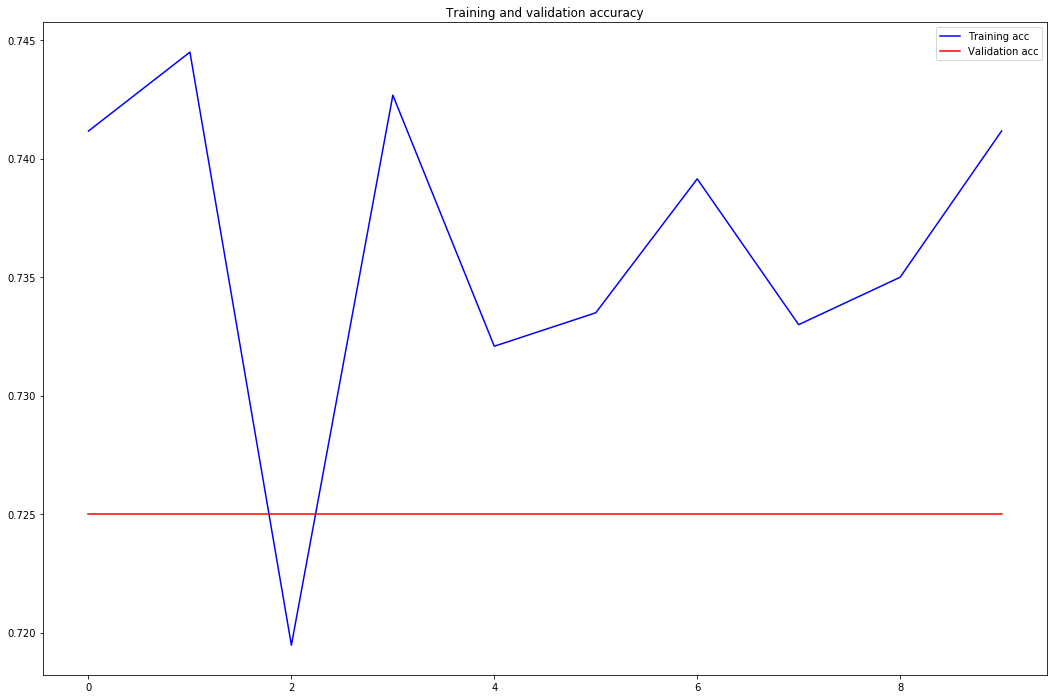

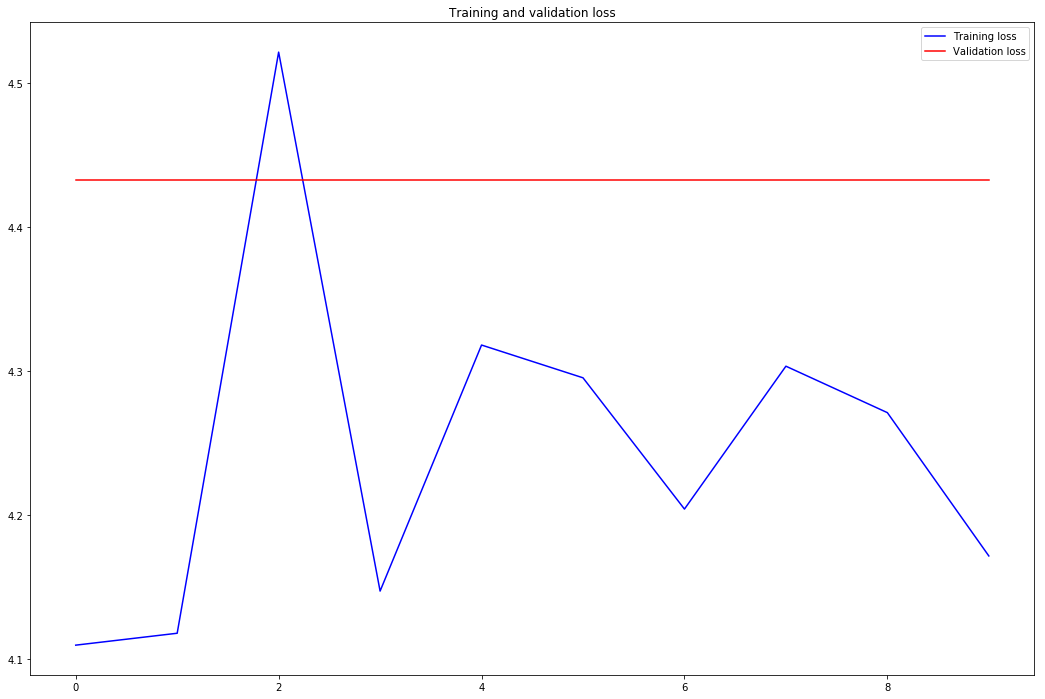

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(18,12))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(18,12))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Testing

In [0]:
test_dir = './gdrive/My Drive/Dataset/test/'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='sparse')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1574 images belonging to 5 classes.
test acc: 0.74
